### Question 9:
At first we import required libraries.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

Now we import a dataset using sklearn's datasets module.

In [30]:
noisy_moons = list(datasets.make_moons(n_samples = 500, noise = .11))

The next step is to extract X and from this dataset.

In [31]:
X_moons = noisy_moons[0]
y_moons = noisy_moons[1]

Now we draw the scatterplot of this data.

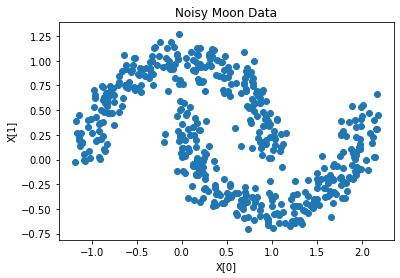

In [32]:
plt.scatter(X_moons[:, 0], X_moons[:, 1])
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.title("Noisy Moon Data")
plt.show()

Now we define a function to draw conyour for us.

In [101]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

The next step is to define Gaussian mixture model.

In [128]:
class GMM:
    def __init__(self, k, max_iter = 5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape
        self.phi = np.full(shape = self.k, fill_value = 1 / self.k)
        self.weights_ = np.full(shape = self.shape, fill_value = 1 / self.k)
        random_row = np.random.randint(low = 0, high = self.n, size = self.k)
        self.means_ = [X[row_index,:] for row_index in random_row]
        self.covariances_ = [np.cov(X.T) for _ in range(self.k)]

    def expextationStep(self, X):
        self.weights_ = self.predictP(X)
        self.phi = self.weights_.mean(axis=0)
    
    def maximizationStep(self, X):
        for i in range(self.k):
            weight_ = self.weights_[:, [i]]
            total_weight = weight_.sum()
            self.means_[i] = (X * weight_).sum(axis = 0) / total_weight
            self.covariances_[i] = np.cov(X.T, aweights = (weight_ / total_weight).flatten(), bias=True)

    def fit(self, X):
        self.initialize(X)
        for iteration in range(self.max_iter):
            self.expextationStep(X)
            self.maximizationStep(X)
            
    def predictP(self, X):
        likelihood = np.zeros((self.n, self.k))
        for i in range(self.k):
            distribution = multivariate_normal(mean = self.means_[i], cov = self.covariances_[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis = 1)[:, np.newaxis]
        weights_ = numerator / denominator
        return weights_
    
    def predict(self, X):
        weights_ = self.predictP(X)
        return np.argmax(weights_, axis = 1)

Now we define a handler function that uses draw_ellipse function and plots contours amo

In [139]:
def plotGMM(model, X):
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c = model.predict(X), s = 20, cmap = 'viridis', zorder = 2)
    ax.axis('equal')
    m = 0
    for w in model.weights_:
        w_norm = np.linalg.norm(w) 
        if w_norm > m:
            m = w_norm
    w_factor = 0.2 / m
    for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
        w_norm = np.linalg.norm(w) 
        draw_ellipse(pos, covar, alpha = w_norm * w_factor)

Means:  [array([ 0.42657176, -0.14347887]), array([0.57219492, 0.55974668])] Covariances:  [array([[ 0.76399698, -0.22206689],
       [-0.22206689,  0.12584316]]), array([[ 0.78554463, -0.22926408],
       [-0.22926408,  0.15606674]])]


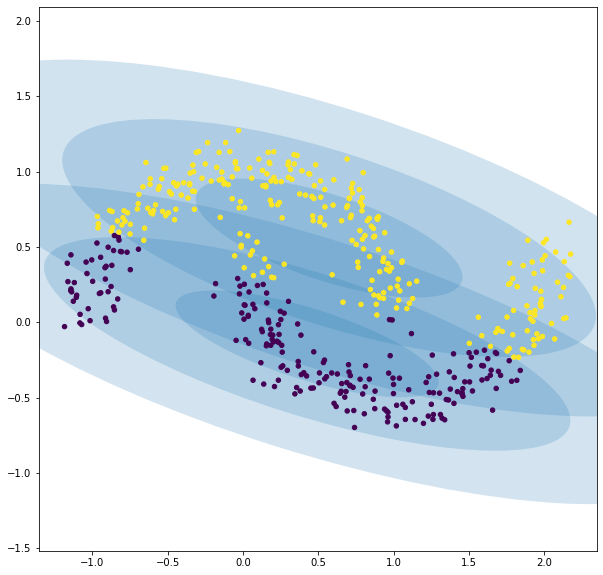

In [141]:
fig = plt.figure(figsize=(10, 10))
model = GMM(k = 2, max_iter = 10)
model.fit(X_moons)
print("Means: ", model.means_, "Covariances: ", model.covariances_)
plotGMM(model, X_moons)

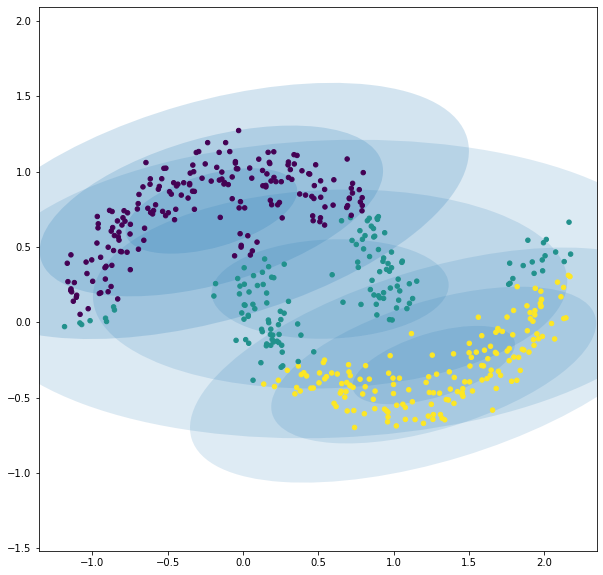

In [142]:
fig = plt.figure(figsize=(10, 10))
model = GMM(k = 3, max_iter = 10)
model.fit(X_moons)
plotGMM(model, X_moons)

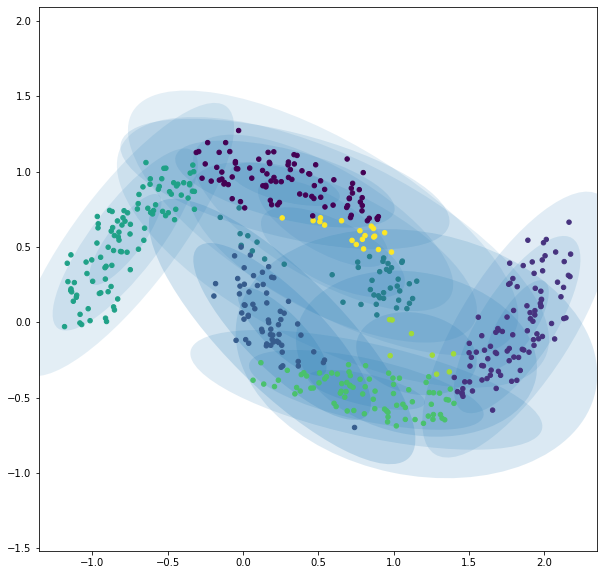

In [143]:
fig = plt.figure(figsize=(10, 10))
model = GMM(k = 8, max_iter = 10)
model.fit(X_moons)
plotGMM(model, X_moons)

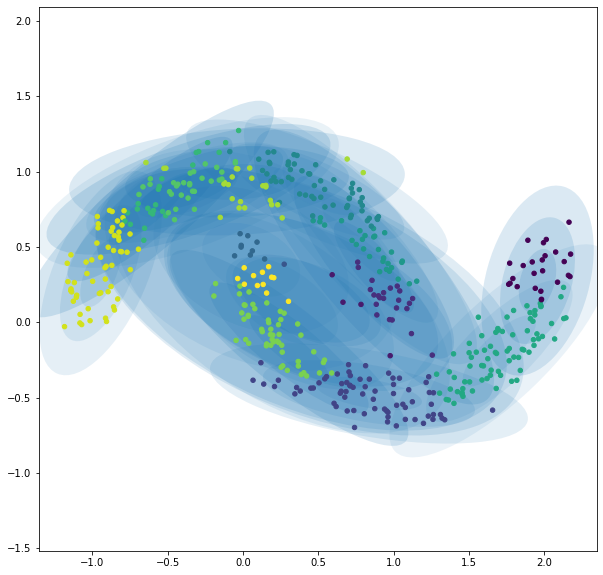

In [144]:
fig = plt.figure(figsize=(10, 10))
model = GMM(k = 16, max_iter = 10)
model.fit(X_moons)
plotGMM(model, X_moons)